In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from ripser import ripser
from ripser import Rips
import persim
from datetime import datetime, timedelta
import pytz
timezone =  pytz.FixedOffset(-240)

In [8]:
# Get the path of the notebook file
notebook_path = os.path.abspath('__file__')

# Directory containing the notebook file
notebook_directory = os.path.dirname(notebook_path)

In [9]:
# Specify the path to your Parquet file
parquet_file_path = notebook_directory+'/Data/train_series.parquet'

# If you want to convert the Table to a Pandas DataFrame, you can do the following:
df = pd.read_parquet(parquet_file_path)

## Filtering rows with the specific series ID

In [10]:
# Specify the 'series_id' you want to filter by
target_series_id = '038441c925bb'

# Filter rows with the specified 'series_id'
filtered_df = df[df['series_id'] == target_series_id]

# Display the filtered DataFrame
print(len(filtered_df))

389880


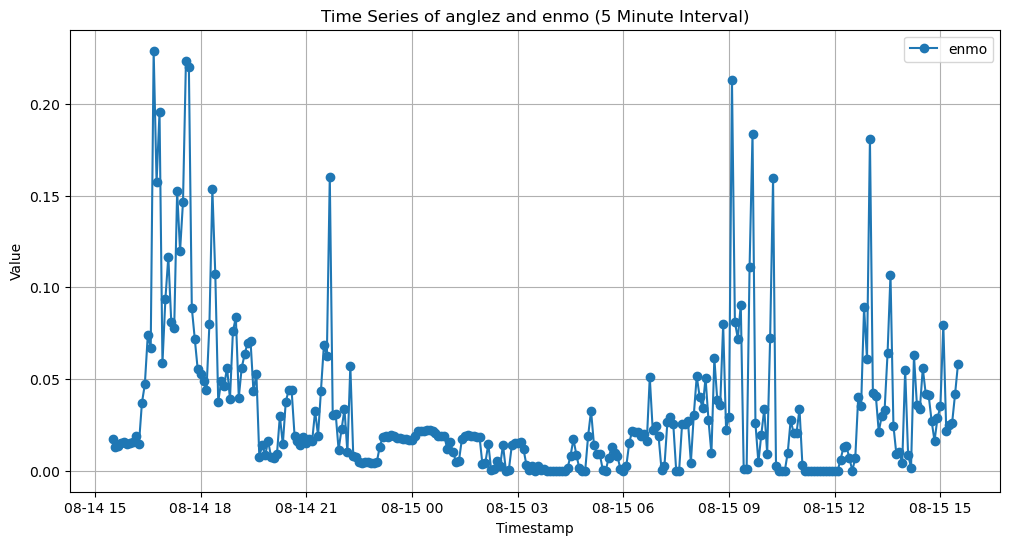

In [22]:
# Assuming you already have a DataFrame named 'filtered_rows' with your data
new_df = filtered_df.loc[0:12*60*24].copy()

# Convert the 'timestamp' column to a datetime format for the new DataFrame
new_df['timestamp'] = pd.to_datetime(new_df['timestamp'])

# Set 'timestamp' as the index for time series plotting
new_df.set_index('timestamp', inplace=True)

# Downsample the data to a half-hour interval and calculate the mean
downsampled_df = new_df.resample('5T').mean(numeric_only = True)

# Plot the downsampled time series of 'anglez' and 'enmo' values
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
#plt.plot(downsampled_df.index, downsampled_df['anglez'], marker='o', linestyle='-', label='anglez')
plt.plot(downsampled_df.index, downsampled_df['enmo'], marker='o', linestyle='-', label='enmo')
plt.title('Time Series of anglez and enmo (5 Minute Interval)')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.grid(True)
plt.legend()  # Add a legend to distinguish between 'anglez' and 'enmo'
plt.show()

## Getting Time Series Embedding

The following function take "time_series" as input. For that particular time_series it will filter the entries which has "series_id" as series Id number. Then using the "start_time" and "end_time" it will create separate time series. For example, if your time series for a specific series Id has entries for 20 days. Then the function will create 20 different time series with entries between start_time on one day and end_time on the next day. Then for time series for each day it will use step_size to create an embedding. For example, if step size is 12 and total entries in time series is 20. Then it will give 8 points in 12 dimension as embedding.

In [8]:
def generate_point_cloud_embedding(time_series,series_id_num,start_time,end_time,step_size):
    #times_series: Is the series that we are considering
    #series_id_num: Is the series that we are targeting
    #start_time and end_time: Is the start and end time for every day when we want our embedding to start from
    #step_size: is the size that we want to embed for

    # Specify the 'series_id' you want to filter by
    target_series_id = series_id_num

    # Filter rows with the specified 'series_id'
    filtered_time_series = time_series[time_series['series_id'] == target_series_id]

    embedding_for_diff_days_anglez = []
    embedding_for_diff_days_enmo = []
    input_df = filtered_time_series.copy()

    # Assuming your data is in a DataFrame named input_df
    input_df['timestamp'] = pd.to_datetime(input_df["timestamp"])

    # Define the time range for start and end times
    start_time = pd.to_datetime(start_time).time()
    end_time = pd.to_datetime(end_time).time()

    # Filter the rows within the time range for each day
    filtered_time_series_by_date = []
    for date in input_df['timestamp'].dt.date.unique():
        
        #start time for every day
        start = datetime.combine(date,start_time).replace(tzinfo=timezone)
        
        #end time for the next day
        end = datetime.combine(date+timedelta(days=1),end_time).replace(tzinfo=timezone)
        
        day_data = input_df[(input_df['timestamp'] >= start) & (input_df['timestamp'] <= end)]
        
        filtered_time_series_by_date.append(day_data)
    for x in filtered_time_series_by_date:
        embedding_anglez = []
        embedding_enmo = []
        j = 0
        while j < len(x)-step_size:
            embed_anglez = []
            embed_enmo = []
            for i in range(step_size):
                embed_anglez.append(x["anglez"].iloc[j+i])
                embed_enmo.append(x["enmo"].iloc[j+i])
            embedding_anglez.append(embed_anglez)
            embedding_enmo.append(embed_enmo)
            j += 1
        if len(embedding_anglez)!=0:
            embedding_for_diff_days_anglez.append(np.array(embedding_anglez))
            embedding_for_diff_days_enmo.append(np.array(embedding_enmo))


    return embedding_for_diff_days_anglez,embedding_for_diff_days_enmo

## Generating Persistence Diagram different step size for a selected time series for a selected day.

In [9]:
selected_series = df.series_id.unique()[5]
day = 5

In [10]:
time_series_embed_anglez_dic = {}
time_series_embed_enmo_dic = {}
ripser_anglez_dic = {}
ripser_enmo_dic = {}

In [170]:
rips = Rips(maxdim=1)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [1]:
# for i in []:
#     #time_series_embed_anglez_dic[i],time_series_embed_enmo_dic[i] = generate_point_cloud_embedding(df,selected_series,"12:00:00","12:00:00",i)
#     ripser_enmo_dic[i]  = rips.fit_transform(time_series_embed_enmo_dic[i][day])
#     # plot_diagrams(ripser_enmo_dic[i]["dgms"],show=True,title=str(i)+" enmo ")

## The code for generating persistence landsacpe for a fixed step size for differnt time series and different days.

In [162]:
dgm = rips.fit_transform(time_series_embed_enmo_dic[100][day])

In [165]:
dgm_200 = rips.fit_transform(time_series_embed_enmo_dic[200][day])

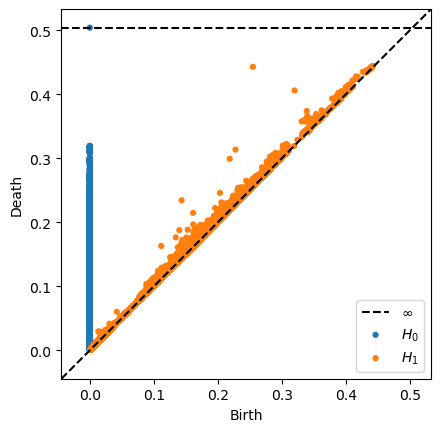

In [163]:
persim.plot_diagrams(dgm,show=True)

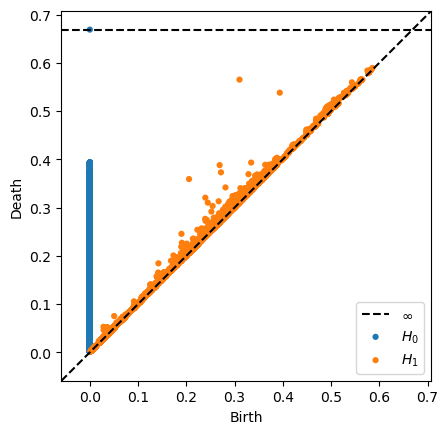

In [166]:
persim.plot_diagrams(dgm_200,show=True)

In [131]:
landscaper = persim.landscapes.PersistenceLandscaper(hom_deg=1)
# Compute flattened persistence landscape
landscaper.fit(dgm)
result = landscaper.transform(dgm)

In [167]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

data = time_series_embed_enmo_dic[100][day]
# Assuming you have already performed PCA and have 'reduced_data'
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Create a DataFrame from the reduced data
plot_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])

# Add a new column for the rank of each point
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Create an interactive 3D scatter plot using Plotly, coloring by rank
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Rank')

# Customize the plot layout, labels, and other settings as needed
fig.update_layout(
    title='PCA Plot in 3D with Rank-based Coloring 100 step size'
)

fig.update_traces(marker_size = 2)

# Show the plot
fig.show()


In [168]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

data = time_series_embed_enmo_dic[200][day]
# Assuming you have already performed PCA and have 'reduced_data'
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Create a DataFrame from the reduced data
plot_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])

# Add a new column for the rank of each point
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Create an interactive 3D scatter plot using Plotly, coloring by rank
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Rank')

# Customize the plot layout, labels, and other settings as needed
fig.update_layout(
    title='PCA Plot in 3D with Rank-based Coloring 200 step size'
)

fig.update_traces(marker_size = 2)

# Show the plot
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

data = time_series_embed_enmo_dic[5][day]
# Assuming you have already performed PCA and have 'reduced_data'
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(data)

# Create a DataFrame from the reduced data
plot_df = pd.DataFrame(data=reduced_data, columns=['PC1', 'PC2', 'PC3'])

# Add a new column for the rank of each point
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Create an interactive 3D scatter plot using Plotly, coloring by rank
fig = px.scatter_3d(plot_df, x='PC1', y='PC2', z='PC3', color='Rank')

# Customize the plot layout, labels, and other settings as needed
fig.update_layout(
    title='PCA Plot in 3D with Rank-based Coloring 5 step size'
)

fig.update_traces(marker_size = 2)

# Show the plot
fig.show()
